In [1]:
import numpy as np
from itertools import product,combinations
import matplotlib.pyplot as plt
from math import log
import scipy.stats

### major functions

In [2]:
def design_matrix(n):
    D=[]
    for i in product([-1,+1],repeat=n):
        D.append(list(i))
    return D

In [3]:
def effect_matrix(d):
    dm=np.flip(d,1)
    (r,c)=np.shape(dm)
    x=''
    for i in range(c):
        x+=str(i)
    labels=[]
    for i in range(c-1):
        for j in combinations(x,i+2):
            labels.append(list(map(int,j)))
    for i in range(len(labels)):
        I=np.full(r,1)
        for j in labels[i]:
            I=I*dm[:,j]
        dm=np.insert(dm,np.shape(dm)[1],I,1)
    return (dm,labels)

In [4]:
def effects(e,R):
    avg=np.mean(R,axis=0)
    e=e.astype('float64')
    for i in range(len(e)):
        for j in range(len(e[i])):
            e[i][j]=e[i][j]*avg[i]
    return e

In [5]:
def eff_det(E,labels,R):
    AVG=np.mean(R)
    e=[("AVG",AVG)]
    labels2=[]
    for i in labels[-1]:
        labels2.append([i])
    labels2.extend(labels)
    (r,c)=np.shape(E)
    for i in range(c):
        e.append((l2str(labels2[i]),np.sum(E[:,i])/(2**(len(labels[-1])-1))))
    if len(R)==2:
        N=2*len(R[0])
        s2=np.sum((R[0]-R[1])**2)/(2*len(R[0]))
        V_eff=(4/N)*s2
        sd_eff=np.sqrt(V_eff)
        V_ave=(s2/N)
        sd_ave=np.sqrt(V_ave)
        return (e,sd_eff,sd_ave)
    else:
        return(e)
    

In [6]:
def significants(eff_ints,sd_ave,sd_eff,DOF,a):
    t_crit=scipy.stats.t.ppf(q=1-a,df=DOF)
    sig=[]
    if eff_ints[0][1]/sd_ave>=t_crit:
        sig.append(eff_ints[0])
    for i in range(1,len(eff_ints)):
        if eff_ints[i][1]/sd_eff>=t_crit:
            sig.append(eff_ints[i])
    return sig

In [7]:
def seq_eval(sig,seq=''): #,extremes):
    if seq:
        val=sig[0][1]
        for i in range(len(seq)):
            if seq[i]=="+":
                val+=(sig[i+1][1]/2)*1 #extremes[i][1]
            elif seq[i]=="-":
                val+=(sig[i+1][1]/2)*(-1) #extremes[i][0]
    return val            

In [8]:
def model_eval(sig,seq_list): #,extremes):
    L=[]
    for seq in seq_list:
        L.append((seq,seq_eval(sig,seq)))
    return L  

In [9]:
#all main effects considered
def model(dm,eff_ints,order=1): #,extremes):
    n=log(len(dm),2)
    est=[]
    for i in range(len(dm)):
        val=eff_ints[0][1]
        for j in range(len(dm[i])):
            val+=((eff_ints[j+1][1])/2)*dm[i][j] #extremes[j][1/0]
        est.append(val)
    return (est)

In [10]:
def resi(A,R):
    avg=np.mean(R,axis=0)
    res=[]
    for i in range(len(avg)):
        res.append(avg[i]-A[i])
    return res

In [11]:
def prob_plot(A,label,title=''):
    m=len(A)
    Pi=[(100/m)*(i-0.5) for i in range(1,m+1)]
    A.sort()
    plt.scatter(A,Pi)
    plt.axvline(x=0, c="black")
    plt.axhline(y=0, c="black")
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.title(label+" Vs "+ "Probability"+title)

### minor functions

In [12]:
def l2str(A):
    x=''
    for i in A:
        x+=str(i)
    return x

In [13]:
def dm2strL(dm):
    L=[]
    for i in range(len(dm)):
        x=''
        for j in range(len(dm[i])):
            if dm[i][j]==1:
                x+='+'
            elif dm[i][j]==-1:
                x+='-'
        L.append(x)
    return (L)

### Model formation

In [14]:
R=np.array([[0.38,0.59,0.58,0.79,
    0.27,0.53,0.30,0.53,
    0.40,0.62,0.56,0.75,
    0.30,0.50,0.32,0.54]])
extremes=[(5,7),(40,45),(10,20),(150,180)]
n=4
A=design_matrix(n)
A=np.array(A)
E=effect_matrix(A)
E1=effects(E[0],R)
eff_ints=eff_det(E1,E[1],R)
eff_ints

[('AVG', 0.4975),
 ('0', 0.21749999999999997),
 ('1', 0.0975),
 ('2', -0.1725),
 ('3', 0.002500000000000009),
 ('01', -0.0049999999999999906),
 ('02', 0.010000000000000023),
 ('03', -0.010000000000000016),
 ('12', -0.07500000000000004),
 ('13', -0.009999999999999988),
 ('23', 0.004999999999999984),
 ('012', 0.002500000000000016),
 ('013', 0.0024999999999999814),
 ('023', -0.007499999999999986),
 ('123', 0.01750000000000001),
 ('0123', 0.010000000000000016)]

### ignoring higher order terms

In [15]:
k=11  #order>3 terms insignificant
sum=0
for i in range(len(eff_ints[k:])):
    sum+=(eff_ints[k:][i][1])**2
s2effect=sum/len(eff_ints[k:])
s2=((len(R[0]))/4)*s2effect
s=np.sqrt(s2)
sd_avg=np.sqrt(s2/len(R[0]))
print("s: ",s)
print("sd_avg: ",sd_avg)

s:  0.01949358868961794
sd_avg:  0.004873397172404485


In [16]:
a=0.05
DOF=len(eff_ints[k:])
sig=significants(eff_ints,sd_avg,s,DOF,a)
sig

[('AVG', 0.4975), ('0', 0.21749999999999997), ('1', 0.0975)]

### probability plot

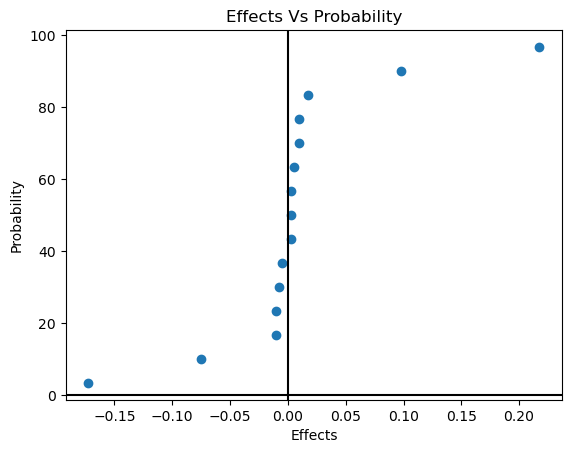

In [17]:
prob_plot([eff_ints[i][1] for i in range(1,len(eff_ints))],label="Effects")

### Residuals

In [18]:
B=design_matrix(len(sig)-1)
seq_list=dm2strL(B)

In [19]:
L=model_eval(sig,seq_list)
L

[('--', 0.34),
 ('-+', 0.43750000000000006),
 ('+-', 0.5575),
 ('++', 0.6549999999999999)]

In [20]:
"""
residuals=resi(A,R) #fill manually
residuals

"""

'\nresiduals=resi(A,R) #fill manually\nresiduals\n\n'

In [21]:
"""
prob_plot(residuals,'Residuals')

"""

"\nprob_plot(residuals,'Residuals')\n\n"

In [22]:
#all main effects considered
M=model(A,eff_ints) #,extremes)
residuals=resi(M,R)
residuals

[-0.044999999999999984,
 0.16249999999999992,
 0.32749999999999996,
 0.5349999999999999,
 -0.25250000000000006,
 0.0050000000000000044,
 -0.050000000000000044,
 0.17749999999999994,
 -0.24250000000000005,
 -0.025000000000000022,
 0.09000000000000008,
 0.27749999999999997,
 -0.44,
 -0.24249999999999994,
 -0.2474999999999999,
 -0.029999999999999805]

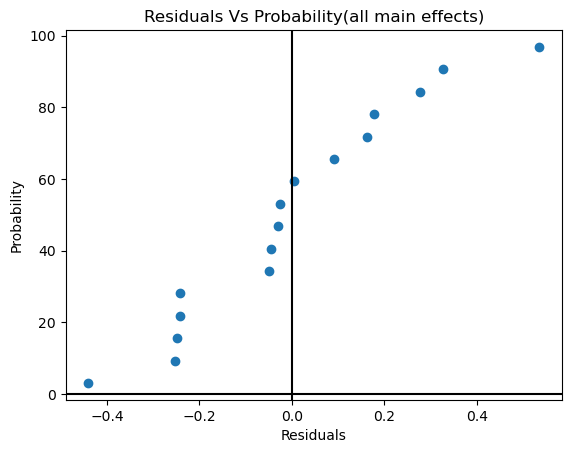

In [23]:
prob_plot(residuals,'Residuals',title="(all main effects)")

In [24]:
E

(array([[-1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1],
        [-1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1],
        [ 1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1],
        [-1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1],
        [ 1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1],
        [-1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1],
        [ 1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1],
        [-1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1],
        [ 1, -1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1],
        [-1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],
        [ 1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1],
        [-1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1],
        [-1,  1,  1,